# HW_05 : CNN Нейросети в обработке текста

Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

DATA_PATH = '../data/отзывы за лето.xls'

<b>Настройка GPU</b>

In [3]:
import tensorflow as tf
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[3], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
# глобальные переменнные для предобработки
max_words = 2000
max_len = 40

In [5]:
df = pd.read_excel(DATA_PATH, parse_dates=[2])
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


### Бинарная классификация

In [6]:
df_bin = df[df['Rating']!=3]

In [7]:
df_bin['Target'] = (df['Rating']>3).astype('uint8')

In [8]:
# распределение не очень, но рабочее
df_bin.Target.value_counts(normalize=True)

1    0.846871
0    0.153129
Name: Target, dtype: float64

#### Препроцессинг

In [9]:
# !pip install -U pymorphy2-dicts-ru


In [10]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [11]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_bin['Content'] = df_bin['Content'].apply(preprocess_text)

In [12]:
# разобьем датасет на трайн-валид-тест 70-15-15
train, test = train_test_split(df_bin, test_size=0.7, shuffle=True, stratify = df_bin['Target'], random_state=42)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

In [13]:
train_corpus = " ".join(train["Content"])
train_corpus = train_corpus.lower()

In [14]:
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [15]:
# наиболее часто встречающиеся токены
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [16]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [17]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [18]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["Content"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in valid["Content"]], dtype=np.int32)

In [19]:
x_train.shape

(5924, 40)

In [20]:
x_train[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 648,  19, 122, 190, 959, 959,
       959], dtype=int32)

### Модель

In [21]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping 

In [84]:
num_classes = 2
y_train = k.utils.to_categorical(train["Target"], num_classes)
y_test = k.utils.to_categorical(test["Target"], num_classes)
y_valid = k.utils.to_categorical(valid["Target"], num_classes)

In [85]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 10))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

In [86]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 128)           256000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 31, 128)           163968    
_________________________________________________________________
activation_18 (Activation)   (None, 31, 128)           0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                2580      
_________________________________________________________________
activation_19 (Activation)   (None, 20)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)               

In [88]:
epochs = 50
batch_size = 512

In [89]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
11/11 [==============================] - 1s 79ms/step - loss: 0.5401 - accuracy: 0.8331 - val_loss: 0.3857 - val_accuracy: 0.8668
Epoch 2/50
11/11 [==============================] - 0s 12ms/step - loss: 0.4624 - accuracy: 0.8443 - val_loss: 0.3714 - val_accuracy: 0.8668
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.4043 - accuracy: 0.8573 - val_loss: 0.3243 - val_accuracy: 0.8803
Epoch 4/50
11/11 [==============================] - 0s 11ms/step - loss: 0.3413 - accuracy: 0.8875 - val_loss: 0.2594 - val_accuracy: 0.9005
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.2688 - accuracy: 0.9145 - val_loss: 0.2239 - val_accuracy: 0.9089
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.2185 - accuracy: 0.9306 - val_loss: 0.2084 - val_accuracy: 0.9123
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.1876 - accuracy: 0.9447 - val_loss: 0.2054 - val_accuracy: 0.9191
Epoch 8/50
11

In [90]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [91]:
def plot_metrics(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

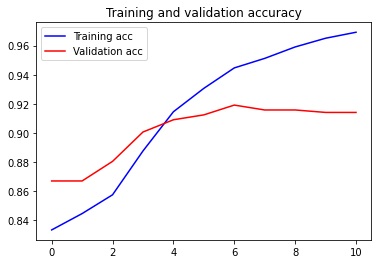

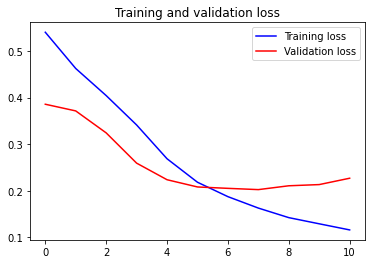

In [92]:
plot_metrics(history)

In [93]:
score = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9110


Test score: 0.2110237181186676
Test accuracy: 0.9110243320465088


In [94]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

14/14 [==============================] - 0s 2ms/step


In [95]:
print(f'Test score: {round(roc_auc_score(y_test, results),3)}')

Test score: 0.955


### 2 часть: Предобучаем word2vec

In [96]:
from gensim.models import Word2Vec

In [97]:
df_bin.iloc[:10]

,Rating,Content,Date,Target
0,5,it just works,2017-08-14,1
1,4,целое удобноной приложениеиз минус хотеть боль...,2017-08-14,1
2,5,отлично,2017-08-14,1
3,5,зависать 1 работа антивирус ранее пользоваться...,2017-08-14,1
4,5,удобно работать быстро,2017-08-14,1
5,5,удобно норма 👍👍👍,2017-08-14,1
6,5,удобный приложение,2017-08-14,1
7,5,устраивать,2017-08-14,1
8,5,работать чётко отличие банкомат вечно зависать...,2017-08-14,1
9,5,хорошо👍,2017-08-14,1


In [98]:
# преобразуем наш датасет в массив массивов для w2v
pre_w2v_list = df_bin.Content.apply(lambda x: [x]).to_list()

In [99]:
modelW2V = Word2Vec(sentences=pre_w2v_list,
                    size=100,
                    window=5,
                    min_count=2,
                    workers=-1)

In [ ]:
# Далее нужно подумать как пристроить полученную модель ко входу в нейросеть